# Customer churn
The customer churn, also known as customer attrition, refers to the phenomenon whereby a customer leaves a company. Some studies confirmed that acquiring new customers can cost five times more than satisfying and retaining existing customers. As a matter of fact, there are a lot of benefits that encourage the tracking of the customer churn rate, for example:
* Marketing costs to acquire new customers are high. Therefore, it is important to retain customers so that the initial investment is not
wasted;
* It has a direct impact on the ability to expand the company;
* etc.

In this project our goal is to predict the probability of a customer is likely to churn using machine learning techniques.


- <a href='#1'>1. Load Data</a>
- <a href='#2'>2. Data Manipulation</a>
- <a href='#3'>3. Exploratory Data Analysis</a>
    - <a href='#3.1'>3.1. Customer churn in data</a>
    - <a href='#3.2'>3.2. Distribution of categorical variables</a>
    - <a href='#3.3'>3.3. Distribution of continuous variables</a>
    - <a href='#3.4'>3.4. Finding missing values</a>
    - <a href='#3.5'>3.5. Correlation matrix</a>
    - <a href='#3.6'>3.6. Detecting and handling outliers</a>
- <a href='#4'>4. Data preparation</a>
- <a href='#5'>5. Feature engineering for the baseline model</a>
    - <a href='#5.1'>5.1. Feature importance</a>
- <a href='#6'>6. Selecting the machine learning algorithms</a>
    - <a href='#6.1'>6.1. Train and build baseline model</a>
        - <a href='#6.2'>6.1.1 Splitting the dataset</a>
        - <a href='#6.3'>6.1.2. Model fitting</a>
    - <a href='#6.4'>6.2. Testing the baseline model</a>
    - <a href='#6.4'>6.3. ROC-AUC performance for the models</a>
- <a href='#7'>7. Optimization</a>
    - <a href='#6.1'>7.1. Implementing a cross-validation based approach</a>
    - <a href='#6.2'>7.2. Implementing hyperparameter tuning</a>
    - <a href='#6.3'>7.3. Train models with the help of new hyperparameter</a>
    - <a href='#6.4'>7.4. Problem with the optimization approach</a>
        - <a href='#6.5'>7.4.1. Feature transformation</a>
        - <a href='#6.5'>7.4.2. Voting-based ensemble model</a>
        - <a href='#6.5'>7.4.2.1. Transformed data</a>
        - <a href='#6.5'>7.4.2.2. Untransformed data</a>
- <a href='#7'>8. Conclusion</a>

In [1]:
# Libraries
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #visualization
import matplotlib.pyplot as plt #visualization
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings("ignore")
import os
import io
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization
#print(os.listdir("../input"))

# Load Data

In [2]:
# Read the training dataset
training_data = pd.read_csv('./data/Churn_Modelling.csv')

# Data Manipulation

In [3]:
# Print the first 5 lines of the dataset
training_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


We can see that the columns name are not consistent.

In [4]:
# Convert all columns heading in lowercase 
clean_column_name = []
columns = training_data.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
training_data.columns = clean_column_name

In [5]:
# Drop the irrelevant columns  as shown above
training_data = training_data.drop(["rownumber", "customerid", "surname"], axis = 1)

In [6]:
#Separating churn and non churn customers
churn     = training_data[training_data["exited"] == 1]
not_churn = training_data[training_data["exited"] == 0]

In [7]:
target_col = ["exited"]
cat_cols   = training_data.nunique()[training_data.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in training_data.columns if x not in cat_cols + target_col]

# Exploratory Data Analysis (EDA)

In [8]:
# Print the first 5 lines of the dataset
training_data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
# View the dimension of the dataset
training_data.shape

(10000, 11)

In [10]:
# Checking for unique value in the data attributes
training_data.nunique()

creditscore         460
geography             3
gender                2
age                  70
tenure               11
balance            6382
numofproducts         4
hascrcard             2
isactivemember        2
estimatedsalary    9999
exited                2
dtype: int64

As we can see the rownumber attribute is just like a counter of records, the customerid attribute is a unique identifier for a given customer and the surname attribute enter also the profiling a customer. So we are going remove them from our dataset they don't give useful information the analysis.

In [11]:
# Drop the irrelevant columns  as shown above
#training_data = training_data.drop(["rownumber", "customerid", "surname"], axis = 1)

In [12]:
# Describe the all statistical properties of the training dataset
training_data[training_data.columns[:10]].describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


In [13]:
# Median
training_data[training_data.columns[:10]].median()

creditscore           652.000
age                    37.000
tenure                  5.000
balance             97198.540
numofproducts           1.000
hascrcard               1.000
isactivemember          1.000
estimatedsalary    100193.915
dtype: float64

In [14]:
# Mean
training_data[training_data.columns[:10]].mean()

creditscore           650.528800
age                    38.921800
tenure                  5.012800
balance             76485.889288
numofproducts           1.530200
hascrcard               0.705500
isactivemember          0.515100
estimatedsalary    100090.239881
dtype: float64

### Customer churn in the data

In [15]:
# Percentage per category for the target column.
percentage_labels = training_data['exited'].value_counts(normalize = True) * 100
percentage_labels

0    79.63
1    20.37
Name: exited, dtype: float64

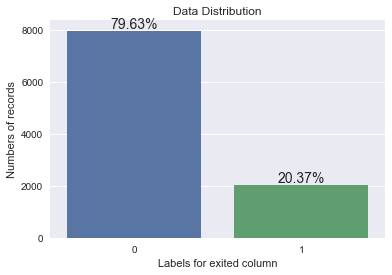

In [16]:
# Graphical representation of the target label percentage.
total_len = len(training_data['exited'])
sns.set()
sns.countplot(training_data.exited).set_title('Data Distribution')
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100 * (height/total_len)),
            fontsize=14, ha='center', va='bottom')
sns.set(font_scale=1.5)
ax.set_xlabel("Labels for exited column")
ax.set_ylabel("Numbers of records")
plt.show()

From this chart, one can see that there are many records with the target label $0$ and fewer records with the target label $1$. One can see that the data records with a $0$ label are about $79.63 \%$, whereas $20.37 \%$ of the data records are labeled $1$. We will use all of these facts in the upcoming sections. For now, we can consider our outcome variable as imbalanced.

### Distribution of the categorical variables

In [17]:
#function  for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)
#for all categorical columns plot pie
#for i in cat_cols :
    #plot_pie(i)

In [18]:
# Calling the function for plotting the pie plot for geography column
plot_pie(cat_cols[0])

The output above shows us that the among the churned customers those who are are geographycally located in Germay have a high rate of churn with $40\%$, followed by France with $39.8\%$ and Spain with $20.3\%$. For non chun customers France is leading with $52.8\%$, Spain with $25.9\%$ and Germany with $21.3\%$.

In [19]:
# Calling the function for plotting the pie plot for gender column
plot_pie(cat_cols[1])

The output above shows us that for the churn customers female have $55.9\%$, whereas male with $44.1\%$. For the case of non churn customers $57.3\%$ are male and $42.7\%$ are female.

In [20]:
# Calling the function for plotting the pie plot for numofproducts column
plot_pie(cat_cols[2])

The graph above shows that among the churn customers, the rate of those who use one product is very high with $69.2\%$, followed by  those who use two products with $17.1\%$, three products with $10.8\%$, and four products with $2.95\%$. For non churn customers, customers with two products are $53.3\%$, one product are $46.2\%$, and three products are $0.58\%$.

In [21]:
# Calling the function for plotting the pie plot for gender column
plot_pie(cat_cols[3])

The output above shows us that for the churn customers those who possess a card are $69.9\%$, whereas those don't possess are $30.1\%$. For the case of non churn customers $70.7\%$ possess a card and $29.3\%$ don't possess a card.

In [22]:
# Calling the function for plotting the pie plot for geography column
plot_pie(cat_cols[4])

The output above shows us that the among the churned customers those who are not active members have a high rate of churn with $63.9\%$, and active members with $36.1\%$. For non chun customers active members are leading with $55.5\%$, and non active members with $44.5\%$.

### Distribution of the continuous variables

In [23]:
#function  for histogram for customer churn types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

**Note:** For more information on the different plot just pass the mousse hover the graph.

In [24]:
# Calling the function for plotting the histogram for creditscore column 
histogram(num_cols[0])

In [25]:
# Calling the function for plotting the histogram for creditscore column 
# Pass the mouse hover the graph for more information. 
histogram(num_cols[1])

The graph above shows us that the customers with age of 46 are the most churned.

In [26]:
# Calling the function for plotting the histogram for tenure column 
histogram(num_cols[2])

Pass the mouse hover the graph for more information. It shows us that the customers who have been with the bank just for one moth are the most churned.

In [27]:
# Calling the function for plotting the histogram for balance column 
histogram(num_cols[3])

In [28]:
# Calling the function for plotting the histogram for estimatedsalary  column 
histogram(num_cols[4])

## Finding missing values
In order to find the missing values in the dataset, we need to check each and every data attribute. First, we will try to identify which attribute has a missing or null value.

In [29]:
training_data.isnull().sum()

creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

As one can see there is no missing values in the dataset.

## Correlation
The term correlation refers to a mutual relationship or association between quantities. So, here, we will find out what kind of association is present among the different data attributes.

In [30]:
# Get the correlation matrix of the training dataset
training_data[training_data.columns].corr()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
creditscore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
numofproducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
hascrcard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
isactivemember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimatedsalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


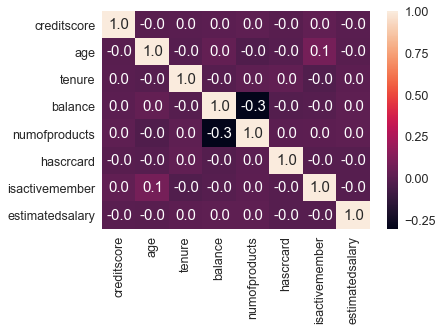

In [31]:
# Visualization of the correlation matrix using heatmap plot
sns.set()
sns.set(font_scale = 1.25)
sns.heatmap(training_data[training_data.columns[:10]].corr(), annot = True,fmt = ".1f")
plt.show()

The following facts can be derived from the graph:
*  Cells with 1.0 values are highly correlated with each other;
* Each attribute has a very high correlation with itself, so all the diagonal values are 1.0;
* balance attribute is negatively correlated with numberofproducts attribute. It means one attribute increases as the other decreases, and vice versa.

Before moving ahead, we need to check whether these attributes contain any outliers or insignificant values. If they do, we need to handle these outliers, so our next section is about detecting outliers from our training dataset.

## Detecting and Handling Outliers
In this part, we will try to detect outliers and how to handle them. 

In [32]:
# Function which plot box plot for detecting outliers
trace = []
def gen_boxplot(df):
    for feature in df:
        trace.append(
            go.Box(
                name = feature,
                y = df[feature]
            )
        )

new_df = training_data[num_cols[:1]]
gen_boxplot(new_df)
data = trace
py.iplot(data)

The box plots above don't  show us any value that are faraway from the min value and also from the max value, so there is  outliers detected.

In [33]:
# Function which plot box plot for detecting outliers
trace = []
def gen_boxplot(df):
    for feature in df:
        trace.append(
            go.Box(
                name = feature,
                y = df[feature]
            )
        )
new_df = training_data[num_cols[1:3]]
gen_boxplot(new_df)
data = trace
py.iplot(data)

The graph tells us that for age there is few outliers. As we can see the two extrem values for the age box plot.

In [34]:
# Handling age column outliers
ageNew = []
for val in training_data.age:
    if val <= 85:
        ageNew.append(val)
    else:
        ageNew.append(training_data.age.median())
        
training_data.age = ageNew

In [35]:
# Function which plot box plot for detecting outliers
trace = []
def gen_boxplot(df):
    for feature in df:
        trace.append(
            go.Box(
                name = feature,
                y = df[feature]
            )
        )
new_df = training_data[num_cols[3:]]
gen_boxplot(new_df)
data = trace
py.iplot(data)

The graph above shows nothing abnormal.

# Data preparation

In [36]:
# One-Hot encoding our categorical attributes
list_cat = ['geography', 'gender']
training_data = pd.get_dummies(training_data, columns = list_cat, prefix = list_cat)

In [37]:
# Print the first five rows
training_data.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,619,42.0,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41.0,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42.0,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39.0,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43.0,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


# Feature engineering for the baseline model
In this section, you will learn how to select features that are important in order to develop the predictive model. So right now, just to begin with, we won't focus much on deriving new features at this stage because first, we need to know which input variables / columns / data attributes / features give us at least baseline accuracy. So, in this first iteration, our focus is on the selection of features from the available training dataset.
## Finding out Feature importance
We need to know which the important features are. In order to find that out, we are going to train the model using the Random Forest classifier. After that, we will have a rough idea about the important features for us.

In [38]:
# Import the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

In [39]:
# We perform training on the Random Forest model and generate the importance of the features
X = training_data.drop('exited', axis=1)
y = training_data.exited
features_label = X.columns
forest = RandomForestClassifier (n_estimators = 10000, random_state = 0, n_jobs = -1)
forest.fit(X, y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i], importances[indices[i]]))

 1) creditscore                    0.239871
 2) age                            0.146924
 3) tenure                         0.144463
 4) balance                        0.141905
 5) numofproducts                  0.128252
 6) hascrcard                      0.083890
 7) isactivemember                 0.039927
 8) estimatedsalary                0.020739
 9) geography_France               0.018099
10) geography_Germany              0.009935
11) geography_Spain                0.008867
12) gender_Female                  0.008583
13) gender_Male                    0.008545


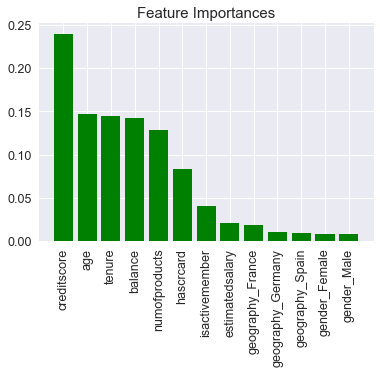

In [40]:
# Visualization of the Feature importances
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], color = "green", align = "center")
plt.xticks(range(X.shape[1]), features_label, rotation = 90)
plt.show()

The graph above shows the features with the highest importance value to the lowest importance value. It shows the most important features are creditscore, age, tenure, balance,  and so on.
We will surely revisit again feature engineering in the upcoming sections.

# Selecting Machine Learning Algorithms
Since we are modeling a critic problem for that we need model with high performance possible. Here, we will try a couple of different machine learning algorithms in order to get an idea about which machine learning algorithm performs better. Also, we will perform a accuracy comparison amoung them. 
As our problem is a classification problem, the algorithms that we are going to choose are as follows:
* K-Nearest Neighbor (KNN)
* Logistic Regression (LR)
* AdaBoost
* Gradient Boosting (GB)
* RandomForest (RF)

## Train and build baseline model

In [41]:
# Import different models 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# Scoring function
from sklearn.metrics import roc_auc_score, roc_curve

In [42]:
X = training_data.drop('exited', axis=1)
y = training_data.exited

As you can see in the code above, variable X contains all the columns except the target column entitled *exited*, so we have dropped this column. The reason behind dropping this attribute is that this attribute contains the answer/target/label for each row. Machine algorithms need input in terms of a key-value pair, so a target column is key and all other columns are values. We can say that a certain pattern of values will lead to a particular target value, which we need to predict using an machine learning algorithm.

#### Splitting the dataset

In [43]:
# Splitting the dataset in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

the code above splits the training  data. We will use $75\%$ of the training data for actual training purposes, and once training is completed, we will use the remaining $25\%$ of the training data to check the training accuracy of our trained  model.

#### Model fitting

In [44]:
# Initialization of the KNN
knMod = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', algorithm = 'auto', leaf_size = 30, p = 2,
                             metric = 'minkowski', metric_params = None)
# Fitting the model with training data 
knMod.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [45]:
# Initialization of the Logistic Regression
lrMod = LogisticRegression(penalty = 'l2', dual = False, tol = 0.0001, C = 1.0, fit_intercept = True,
                            intercept_scaling = 1, class_weight = None, 
                            random_state = None, solver = 'liblinear', max_iter = 100,
                            multi_class = 'ovr', verbose = 2)
# Fitting the model with training data 
lrMod.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=2, warm_start=False)

In [46]:
# Initialization of the AdaBoost model
adaMod = AdaBoostClassifier(base_estimator = None, n_estimators = 200, learning_rate = 1.0)
# Fitting the model with training data 
adaMod.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)

In [47]:
# Initialization of the GradientBoosting model
gbMod = GradientBoostingClassifier(loss = 'deviance', n_estimators = 200)
# Fitting the model with training data 
gbMod.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [48]:
# Initialization of the Random Forest model
rfMod = RandomForestClassifier(n_estimators=10, criterion='gini')
# Fitting the model with training data 
rfMod.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Testing the baseline model
Here, we will implement the code, which will give us an idea about how good or how bad our trained models perform in a validation set. We are using the mean accuracy score and the AUC-ROC score.
We have generated five different classifiers and, after performing testing for each of them on the validation dataset, which is $25\%$ of held-out dataset from the training dataset, we will find out which model works well and gives us a reasonable baseline score.

In [49]:
# Compute the model accuracy on the given test data and labels
knn_acc = knMod.score(X_test, y_test)
# Return probability estimates for the test data
test_labels = knMod.predict_proba(np.array(X_test.values))[:,1]
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
knn_roc_auc = roc_auc_score(y_test, test_labels , average = 'macro', sample_weight = None)

In [50]:
# Compute the model accuracy on the given test data and labels
lr_acc = lrMod.score(X_test, y_test)
# Return probability estimates for the test data
test_labels = lrMod.predict_proba(np.array(X_test.values))[:,1]
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
lr_roc_auc = roc_auc_score(y_test, test_labels , average = 'macro', sample_weight = None)

In [51]:
# Compute the model accuracy on the given test data and labels
ada_acc = adaMod.score(X_test, y_test)
# Return probability estimates for the test data
test_labels = adaMod.predict_proba(np.array(X_test.values))[:,1]
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
ada_roc_auc = roc_auc_score(y_test, test_labels , average = 'macro')

In [52]:
# Compute the model accuracy on the given test data and labels
gb_acc = gbMod.score(X_test, y_test)
# Return probability estimates for the test data
test_labels = gbMod.predict_proba(np.array(X_test.values))[:,1]
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
gb_roc_auc = roc_auc_score(y_test, test_labels , average = 'macro')

In [53]:
# Compute the model accuracy on the given test data and labels
rf_acc = rfMod.score(X_test, y_test)
# Return probability estimates for the test data
test_labels = rfMod.predict_proba(np.array(X_test.values))[:,1]
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
rf_roc_auc = roc_auc_score(y_test, test_labels , average = 'macro')

In [54]:
models = ['KNN', 'Logistic Regression', 'AdaBoost', 'GradientBoosting', 'Random Forest']
accuracy = [knn_acc, lr_acc, ada_acc, gb_acc, rf_acc]
roc_auc = [knn_roc_auc, lr_roc_auc, ada_roc_auc, gb_roc_auc, rf_roc_auc]

d = {'accuracy': accuracy, 'roc_auc': roc_auc}
df_metrics = pd.DataFrame(d, index = models)
df_metrics

,accuracy,roc_auc
KNN,0.7668,0.517174
Logistic Regression,0.7832,0.666015
AdaBoost,0.8520,0.827415
GradientBoosting,0.8620,0.852163
Random Forest,0.8548,0.819822


### ROC-AUC performance for the models

In [55]:
fpr_knn, tpr_knn, _ = roc_curve(y_test, knMod.predict_proba(np.array(X_test.values))[:,1])
fpr_lr, tpr_lr, _ = roc_curve(y_test, lrMod.predict_proba(np.array(X_test.values))[:,1])
fpr_ada, tpr_ada, _ = roc_curve(y_test, adaMod.predict_proba(np.array(X_test.values))[:,1])
fpr_gb, tpr_gb, _ = roc_curve(y_test, gbMod.predict_proba(np.array(X_test.values))[:,1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rfMod.predict_proba(np.array(X_test.values))[:,1])

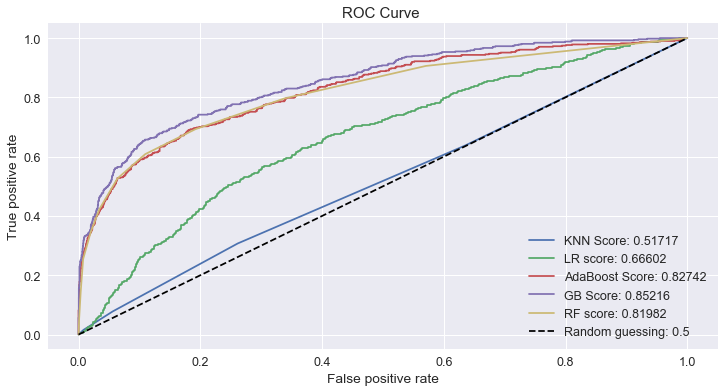

In [56]:
# Plot the roc curve
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_knn, tpr_knn, label = 'KNN Score: ' + str(round(knn_roc_auc, 5)))
plt.plot(fpr_lr, tpr_lr, label = 'LR score: ' + str(round(lr_roc_auc, 5)))
plt.plot(fpr_ada, tpr_ada, label = 'AdaBoost Score: ' + str(round(ada_roc_auc, 5)))
plt.plot(fpr_gb, tpr_gb, label = 'GB Score: ' + str(round(gb_roc_auc, 5)))
plt.plot(fpr_rf, tpr_rf, label = 'RF score: ' + str(round(rf_roc_auc, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random guessing: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve ')
plt.legend(loc='best')
plt.show()

In the code above we used *score()* function of scikit-learn, which give us the mean accuracy score, whereas, the *roc_auc_score()* function  provide us with the ROC-AUC score, which is more significant for us because the mean accuracy score considers only one threshold value, whereas the ROC-AUC score takes into consideration all possible threshold values and gives us the score.

As you can see in the code snippets given above, the GradientBoosting with $0.86$ and the AdaBoost with $0.84$ classifiers get a good ROC-AUC score on the validation dataset. Other classifiers, such as logistic regression, KNN, and RandomForest do not perform well on the validation set. From this stage onward, we will work with GradientBoosting and AdaBoost classifiers in order to improve their accuracy score.

In the next section, we will see what we need to do in order to increase classification accuracy since we want a model with the high accuracy possible.

# Optimization
In this section, we will use the following techniques in order to improve the accuracy of the classifiers :
*  Cross-validation
*  Hyperparameter tuning

## Implementing a cross-validation based approach
Here, we are going to implement K-folds cross-validation. For the value of K, I am going to use $K=5$.

In [57]:
# Import the cross-validation module
from sklearn.model_selection import cross_val_score

# Function that will track the mean value and the standard deviation of the accuracy
def cvDictGen(functions, scr, X_train = X, y_train = y, cv = 5):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv = cv, scoring = scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

In [58]:
mod = [knMod, lrMod, adaMod, gbMod, rfMod]
cvD = cvDictGen(mod, scr = 'roc_auc')
cvD

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

{'AdaBoostClassifier': [0.8441536988337959, 0.005070041641675],
 'GradientBoostingClassifier': [0.8637439499704047, 0.0047361184443237125],
 'KNeighborsClassifier': [0.5329734157422574, 0.015326370948856007],
 'LogisticRegression': [0.6777501420420236, 0.00820438287356029],
 'RandomForestClassifier': [0.812975646551531, 0.006509076220178267]}

As we can see, in the above output, GradietBoosting and Adaboot classifier perform well. This cross-validation score helps in order to decide which model we should select and which ones we should not go with.  Based on the mean value and the standard deviation value, we can conclude that our ROC-AUC score does not deviate much, so we are not suffering from the overfitting issue.

## Implementing hyperparameter tuning
Here, we will look at how we can obtain optimal values for the parameters. So, we are going to use the *RandomizedSearchCV* hyperparameter tuning method. We will implement this method for the AdaBoost and GradientBossting models since they are the one having good performance.

In [59]:
# Import methods
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

### AdaBoost

In [60]:
# Possible parameters
adaHyperParams = {'n_estimators': [10,50,100,200,420]}

In [61]:
gridSearchAda = RandomizedSearchCV(estimator = adaMod, param_distributions = adaHyperParams, n_iter = 5,
                                   scoring = 'roc_auc')
gridSearchAda.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'n_estimators': [10, 50, 100, 200, 420]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [62]:
# Display the best parameters and the score
gridSearchAda.best_params_, gridSearchAda.best_score_

({'n_estimators': 10}, 0.8482854259099849)

The output above shows that the optimal value.

### GradientBoosting

In [63]:
# Possibles parameters
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

In [64]:
# Initialization
gridSearchGB = RandomizedSearchCV(estimator = gbMod, param_distributions = gbHyperParams, n_iter = 10,
                                   scoring = 'roc_auc')
# Fitting the model
gridSearchGB.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'loss': ['deviance', 'exponential'], 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020205E78208>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020205E782B0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [65]:
gridSearchGB.best_params_, gridSearchGB.best_score_

({'loss': 'exponential', 'max_depth': 3, 'n_estimators': 178},
 0.8627837011856309)

The output above shows that the optimal  values

## Train models with help of new hyper parameter
Here we are going to use the optimal parameter values that we got from the hyperparameter tuning.

In [66]:
# GradientBoosting with the optimal parameters
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, y_train)

In [67]:
# AdaBoost with the optimal parameter
bestAdaModFitted = gridSearchAda.best_estimator_.fit(X_train, y_train)

In [68]:
functions = [bestGbModFitted, bestAdaModFitted]
cvDictbestpara = cvDictGen(functions, scr = 'roc_auc')
cvDictbestpara

{'AdaBoostClassifier': [0.8433581299082993, 0.005649160672569516],
 'GradientBoostingClassifier': [0.8648207063386147, 0.004362643398728843]}

In [69]:
# Getting the score GradientBoosting
test_labels = bestGbModFitted.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_labels , average = 'macro', sample_weight = None)

0.8500519983195244

In [70]:
# Getting the score AdaBoost
test_labels = bestAdaModFitted.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_labels , average = 'macro', sample_weight = None)

0.8292452913726082

We can see in the above output that there is no such an improvement.  One can still ask this question : can we further improve the accuracy of the classifiers? Sure, there is always room for improvement.

## Problems with the optimization approach
Up until, we did not spend a lot of time on feature engineering. So in our best possible approach, we spent time on the transformation of features engineering. We need to implement a voting mechanism in order to generate the final probability of the prediction on the actual test dataset so that we can get the best accuracy score.

These are the two techniques that we need to apply:
* Feature transformation
* An ensemble ML model with a voting mechanism

### Feature transformation (Feature engineering)
We will apply standard scaler/log transformation to our training dataset. The reason behind this is that we have some attributes that are very skewed and some data attributes that have values that are more spread out in nature. 

In [71]:
# Import the log transformation method
from sklearn.preprocessing import FunctionTransformer, StandardScaler

In [72]:
transformer = FunctionTransformer(np.log1p)
scaler = StandardScaler()
X_train_1 = np.array(X_train)
#X_train_transform = transformer.transform(X_train_1)
X_train_transform = scaler.fit_transform(X_train_1)

In [73]:
bestGbModFitted_transformed = gridSearchGB.best_estimator_.fit(X_train_transform, y_train)
bestAdaModFitted_transformed = gridSearchAda.best_estimator_.fit(X_train_transform, y_train)

In [74]:
cvDictbestpara_transform = cvDictGen(functions = [bestGbModFitted_transformed, bestAdaModFitted_transformed],
                                     scr='roc_auc')
cvDictbestpara_transform

{'AdaBoostClassifier': [0.8433581299082993, 0.005649160672569516],
 'GradientBoostingClassifier': [0.8646640539001982, 0.0043596534273555206]}

In [75]:
# For the test set
X_test_1 = np.array(X_test)
#X_test_transform = transformer.transform(X_test_1)
X_test_transform = scaler.fit_transform(X_test_1)

In [76]:
test_labels=bestGbModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]
roc_auc_score(y_test,test_labels , average = 'macro', sample_weight = None)

0.8456107416623129

### Voting-based ensemble model
In this section, we will use a voting-based ensemble classifier. So, we implement a voting-based machine learning model for both untransformed features as well as transformed features. Let's see which version scores better on the validation dataset.

#### For transform data

In [77]:
# Import the voting-based ensemble model
from sklearn.ensemble import VotingClassifier

In [78]:
# Initialization of the model
votingMod = VotingClassifier(estimators=[('gb', bestGbModFitted_transformed), 
                                         ('ada', bestAdaModFitted_transformed)],
                                         voting = 'soft', weights = [2,1])
# Fitting the model
votingMod = votingMod.fit(X_train_transform, y_train)

In [79]:
test_labels=votingMod.predict_proba(np.array(X_test_transform))[:,1]
votingMod.score(X_test_transform, y_test)

C:\Users\X1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



0.862

In [80]:
# The roc_auc score
roc_auc_score(y_test, test_labels , average = 'macro', sample_weight = None)

0.8464381889039424

#### For untransform data

In [81]:
# Initialization of the model
votingMod_old = VotingClassifier(estimators = [('gb', bestGbModFitted), ('ada', bestAdaModFitted)], 
                                 voting = 'soft', weights = [2,1])
# Fitting the model
votingMod_old = votingMod.fit(X_train, y_train)

In [82]:
test_labels = votingMod_old.predict_proba(np.array(X_test.values))[:,1]
votingMod.score(X_test, y_test)

C:\Users\X1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



0.8632

In [83]:
# The roc_auc score
roc_auc_score(y_test,test_labels , average = 'macro', sample_weight = None)

0.8501041442217913

In the both cases above we have achieved about $86\%$ accuracy.  This score is by far the most efficient accuracy as per industry standards.

# Conclusion
In this project we build a model that predict how likely a customer is going to churn. During exploratory data analysis we found out that the female customer are the most likely to churn, customer that are located in Germany are the most churned, and also customer using only one product are the most churned. After building several model we ended up with two  GradientBoosting and AdaBoost which performed better than others followed by Random Forest. We dicided to go further with the two and implemented a voting-based for the two which will allow us to choose the best model. Since the problem is about binary classification with a imbalance dataset, I have used the most efficient metric for model performance which is the ROC-AUC score and my model achieved about $86\%$ accuary. This score is by far the most efficient accuracy as per industry standards. The model can achieve better performance providing a lot of historical data for the training phase. For the next way to explore is may be try to group value in tenure column in trimester, semester and yearly.